In [1]:
!git clone https://github.com/SamsungSAILMontreal/ForestDiffusion

Cloning into 'ForestDiffusion'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 447 (delta 82), reused 129 (delta 72), pack-reused 299 (from 1)
Receiving objects: 100% (447/447), 901.47 KiB | 10.36 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [2]:
!pip install ForestDiffusion

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [3]:
pip install openTSNE


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.3 MB/s eta 0:00:00


In [4]:
pip install "dask[dataframe]"


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 4.6 MB/s eta 0:00:00


Class distribution before augmentation: {0: 284315, 1: 492}


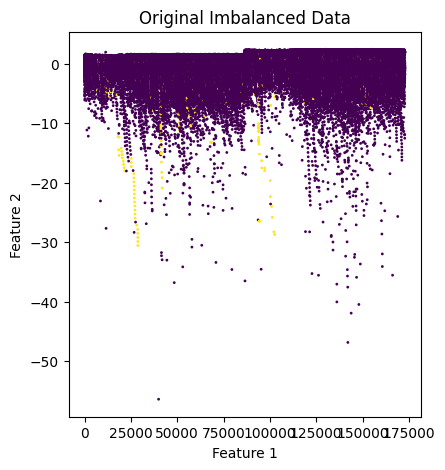

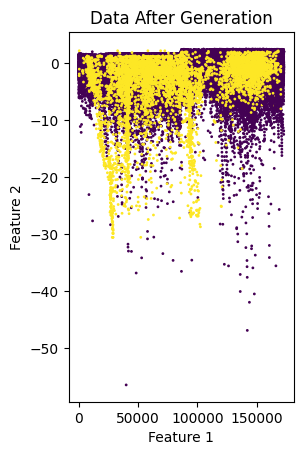

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}
Recall score (original data): 0.8015
Recall score (generated data): 0.9338
F1 score (original data): 0.8685
F1 score (generated data): 0.8850
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.80      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.84      0.93      0.89       136

    accuracy                           1.00     85443
   macro avg       0.92      0.97      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Number of fake samples generated: 5696


ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='covariance_eigh'

In [6]:

# Add your updated code here
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from openTSNE import TSNE

# Step 1: Load the CSV file
#file_path = 'creditcard.csv'  # Update this path to your local CSV file
file_path = '/content/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Separate the minority class
X_minority = X[y == 1]

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)  # Adjust the batch size to create a balanced dataset

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)



# Step 5: Plot the generated data (first two features for visualization)
plt.subplot(1, 2, 2)
plt.scatter(X_balanced[:, 0], X_balanced[:, 1], c=y_balanced, cmap='viridis', label='Generated Data', s=1)
plt.title('Data After Generation')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 8: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 9: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")
print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 10: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")




subset_size = 500
subset_indices = np.random.choice(X_minority_fake.shape[0], subset_size, replace=False)
X_res_subset = X_minority_fake[subset_indices]

# Check the dimensions of the dataset before applying PCA
n_samples, n_features = X_minority.shape
print(f"Number of samples: {n_samples}, Number of features: {n_features}")

# Make sure n_components is not greater than min(n_samples, n_features)
#n_components = min(n_samples, n_features, 30)  # Adjust n_components based on the data

#pca = PCA(n_components=n_components)
#X_minority_pca = pca.fit_transform(X_minority)
#synthetic_minority_pca = pca.fit_transform(X_res_subset)


#  Apply PCA to reduce the dimensionality to 30 components
pca = PCA(n_components=30)
X_minority_pca = pca.fit_transform(X_minority)  # Original data
synthetic_minority_pca = pca.fit_transform(X_res_subset)  # Only 1000 synthetic minority class samples

#  Apply openTSNE for t-SNE visualization (perplexity=30)
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean", n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority_pca)
X_tsne_synthetic = tsne.fit(synthetic_minority_pca)

# Create t-SNE Plot for minority class before and after augmentation
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for synthetic minority class data
ax.scatter(X_tsne_synthetic[:, 0], X_tsne_synthetic[:, 1], c='orange', label='Minority Class (FD)', alpha=0.6)

#  Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD)')
ax.legend()

#  Display the plot
plt.tight_layout()
plt.show()

# Step 11: Apply PCA to reduce the dimensionality of the entire dataset to 30 components
X_pca_orig = pca.fit_transform(X)  # Original entire data
X_pca_balanced = pca.fit_transform(X_balanced)  # Entire dataset after augmentation (including synthetic data)

# Step 12: Apply openTSNE for t-SNE visualization (perplexity=30) on the entire dataset
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean", n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced entire dataset
X_tsne_orig = tsne.fit(X_pca_orig)
X_tsne_balanced = tsne.fit(X_pca_balanced)

# Create t-SNE Plot for the entire dataset before and after augmentation
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original entire dataset
ax.scatter(X_tsne_orig[:, 0], X_tsne_orig[:, 1], c='blue', label='Entire Dataset (Original)', alpha=0.6)
# Plot for the entire dataset after augmentation
ax.scatter(X_tsne_balanced[:, 0], X_tsne_balanced[:, 1], c='orange', label='Entire Dataset (After FD)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Entire Dataset (Before and After FD)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Step 13: Save the original minority class to a CSV file
# Assuming the original minority class has label '1'
original_minority_data = pd.DataFrame(X_minority)  # Convert original minority class to a DataFrame
original_minority_data['label'] = 1  # Add label column

# Save the original minority class data to CSV
original_minority_data.to_csv('original_minority_class.csv', index=False)
print("Original minority class data saved to 'original_minority_class.csv'.")

# Step 14: Save the generated minority class data (after augmentation) to a CSV file
# Convert the generated minority class to a DataFrame
generated_minority_data = pd.DataFrame(X_minority_fake)
generated_minority_data['label'] = 1  # Add label column

# Save the generated minority class data to CSV
generated_minority_data.to_csv('generated_minority_class.csv', index=False)
print("Generated minority class data saved to 'generated_minority_class.csv'.")

# Step 15: Save the entire balanced dataset after augmentation to a CSV file
balanced_data = pd.DataFrame(X_balanced)  # Convert features to a DataFrame
balanced_data['label'] = y_balanced  # Add the labels as a new column

# Save the balanced dataset to CSV
balanced_data.to_csv('balanced_dataset.csv', index=False)
print("Balanced dataset after augmentation saved to 'balanced_dataset.csv'.")



Number of samples: 492, Number of features: 30


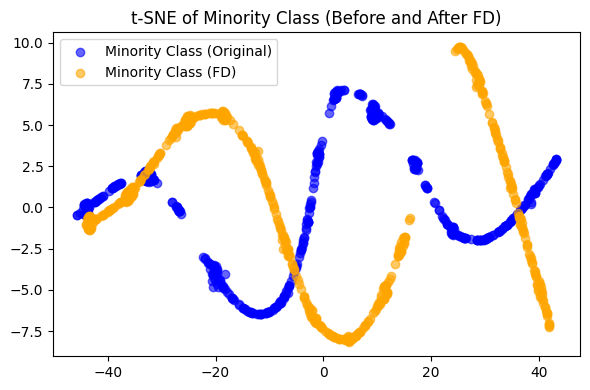

<ipython-input-7-bbce86e56600>:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


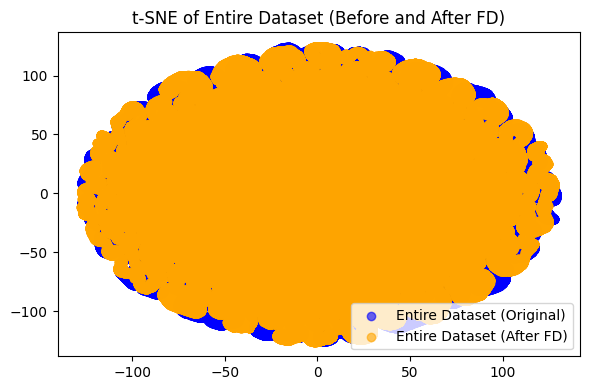

Original minority class data saved to 'original_minority_class.csv'.
Generated minority class data saved to 'generated_minority_class.csv'.
Balanced dataset after augmentation saved to 'balanced_dataset.csv'.


In [7]:
subset_size = 500
subset_indices = np.random.choice(X_minority_fake.shape[0], subset_size, replace=False)
X_res_subset = X_minority_fake[subset_indices]

# Check the dimensions of the dataset before applying PCA
n_samples, n_features = X_minority.shape
print(f"Number of samples: {n_samples}, Number of features: {n_features}")

# Make sure n_components is not greater than min(n_samples, n_features)
#n_components = min(n_samples, n_features, 30)  # Adjust n_components based on the data

#pca = PCA(n_components=n_components)
#X_minority_pca = pca.fit_transform(X_minority)
#synthetic_minority_pca = pca.fit_transform(X_res_subset)


#  Apply PCA to reduce the dimensionality to 30 components
pca = PCA(n_components=30)
X_minority_pca = pca.fit_transform(X_minority)  # Original data
synthetic_minority_pca = pca.fit_transform(X_res_subset)  # Only 1000 synthetic minority class samples

#  Apply openTSNE for t-SNE visualization (perplexity=30)
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean", n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority_pca)
X_tsne_synthetic = tsne.fit(synthetic_minority_pca)

# Create t-SNE Plot for minority class before and after augmentation
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for synthetic minority class data
ax.scatter(X_tsne_synthetic[:, 0], X_tsne_synthetic[:, 1], c='orange', label='Minority Class (FD)', alpha=0.6)

#  Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD)')
ax.legend()

#  Display the plot
plt.tight_layout()
plt.show()

# Step 11: Apply PCA to reduce the dimensionality of the entire dataset to 30 components
X_pca_orig = pca.fit_transform(X)  # Original entire data
X_pca_balanced = pca.fit_transform(X_balanced)  # Entire dataset after augmentation (including synthetic data)

# Step 12: Apply openTSNE for t-SNE visualization (perplexity=30) on the entire dataset
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean", n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced entire dataset
X_tsne_orig = tsne.fit(X_pca_orig)
X_tsne_balanced = tsne.fit(X_pca_balanced)

# Create t-SNE Plot for the entire dataset before and after augmentation
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original entire dataset
ax.scatter(X_tsne_orig[:, 0], X_tsne_orig[:, 1], c='blue', label='Entire Dataset (Original)', alpha=0.6)
# Plot for the entire dataset after augmentation
ax.scatter(X_tsne_balanced[:, 0], X_tsne_balanced[:, 1], c='orange', label='Entire Dataset (After FD)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Entire Dataset (Before and After FD)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Step 13: Save the original minority class to a CSV file
# Assuming the original minority class has label '1'
original_minority_data = pd.DataFrame(X_minority)  # Convert original minority class to a DataFrame
original_minority_data['label'] = 1  # Add label column

# Save the original minority class data to CSV
original_minority_data.to_csv('original_minority_class.csv', index=False)
print("Original minority class data saved to 'original_minority_class.csv'.")

# Step 14: Save the generated minority class data (after augmentation) to a CSV file
# Convert the generated minority class to a DataFrame
generated_minority_data = pd.DataFrame(X_minority_fake)
generated_minority_data['label'] = 1  # Add label column

# Save the generated minority class data to CSV
generated_minority_data.to_csv('generated_minority_class.csv', index=False)
print("Generated minority class data saved to 'generated_minority_class.csv'.")

# Step 15: Save the entire balanced dataset after augmentation to a CSV file
balanced_data = pd.DataFrame(X_balanced)  # Convert features to a DataFrame
balanced_data['label'] = y_balanced  # Add the labels as a new column

# Save the balanced dataset to CSV
balanced_data.to_csv('balanced_dataset.csv', index=False)
print("Balanced dataset after augmentation saved to 'balanced_dataset.csv'.")

